In [46]:
import os
from dotenv import load_dotenv

from typing import Final

import mlflow
import mlflow.entities
import mlflow.data.pandas_dataset
from mlflow.data.sources import (
    LocalArtifactDatasetSource
)

import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)

import pickle

import PIL

In [2]:
load_dotenv()

True

In [3]:
INT8_MIN    = np.iinfo(np.int8).min
INT8_MAX    = np.iinfo(np.int8).max
INT16_MIN   = np.iinfo(np.int16).min
INT16_MAX   = np.iinfo(np.int16).max
INT32_MIN   = np.iinfo(np.int32).min
INT32_MAX   = np.iinfo(np.int32).max

FLOAT16_MIN = np.finfo(np.float16).min
FLOAT16_MAX = np.finfo(np.float16).max
FLOAT32_MIN = np.finfo(np.float32).min
FLOAT32_MAX = np.finfo(np.float32).max

def memory_usage(data, detail=1):
    if detail:
        display(data.memory_usage())
    memory = data.memory_usage().sum() / (1024*1024)
    print("Memory usage : {0:.2f}MB".format(memory))
    return memory

def compress_dataset(data):
    """
        Compress datatype as small as it can
        Parameters
        ----------
        path: pandas Dataframe

        Returns
        -------
            None
    """
    memory_before_compress = memory_usage(data, 0)
    print()
    length_interval      = 50
    length_float_decimal = 4

    print('='*length_interval)
    for col in data.columns:
        col_dtype = data[col][:100].dtype

        if col_dtype != 'object':
            print("Name: {0:24s} Type: {1}".format(col, col_dtype))
            col_series = data[col]
            col_min = col_series.min()
            col_max = col_series.max()

            if col_dtype == 'float64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(np.round(col_min, length_float_decimal)), str(np.round(col_max, length_float_decimal))))
                if (col_min > FLOAT16_MIN) and (col_max < FLOAT16_MAX):
                    data[col] = data[col].astype(np.float16)
                    print("  float16 min: {0:15s} max: {1:15s}".format(str(FLOAT16_MIN), str(FLOAT16_MAX)))
                    print("compress float64 --> float16")
                elif (col_min > FLOAT32_MIN) and (col_max < FLOAT32_MAX):
                    data[col] = data[col].astype(np.float32)
                    print("  float32 min: {0:15s} max: {1:15s}".format(str(FLOAT32_MIN), str(FLOAT32_MAX)))
                    print("compress float64 --> float32")
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                print('='*length_interval)

            if col_dtype == 'int64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(col_min), str(col_max)))
                type_flag = 64
                if (col_min > INT8_MIN/2) and (col_max < INT8_MAX/2):
                    type_flag = 8
                    data[col] = data[col].astype(np.int8)
                    print("     int8 min: {0:15s} max: {1:15s}".format(str(INT8_MIN), str(INT8_MAX)))
                elif (col_min > INT16_MIN) and (col_max < INT16_MAX):
                    type_flag = 16
                    data[col] = data[col].astype(np.int16)
                    print("    int16 min: {0:15s} max: {1:15s}".format(str(INT16_MIN), str(INT16_MAX)))
                elif (col_min > INT32_MIN) and (col_max < INT32_MAX):
                    type_flag = 32
                    data[col] = data[col].astype(np.int32)
                    print("    int32 min: {0:15s} max: {1:15s}".format(str(INT32_MIN), str(INT32_MAX)))
                    type_flag = 1
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                if type_flag == 32:
                    print("compress (int64) ==> (int32)")
                elif type_flag == 16:
                    print("compress (int64) ==> (int16)")
                else:
                    print("compress (int64) ==> (int8)")
                print('='*length_interval)

    print()
    memory_after_compress = memory_usage(data, 0)
    print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))

In [4]:
os.environ["MLFLOW_TRACKING_USERNAME"] = os.getenv("TRACKING_USER")
os.environ["MLFLOW_TRACKING_PASSWORD"] = os.getenv("TRACKING_PSWD")
os.environ["MLFLOW_HTTP_REQUEST_TIMEOUT"] = "9000"

In [5]:
mlflow.set_tracking_uri(f"http://{os.getenv('ADRESS')}:{os.getenv('PORT')}")
CURRENT_EXPERIMENT: mlflow.entities.Experiment = mlflow.set_experiment("Spectrum_EDA")

In [52]:
# DATA SAMPLE, SPECTRUM
# ----------
SAMPLE_PATH: str = "../data/raw/spectr/Выборка_Н22_5_1.csv"
SAMPLE_REST: str = "../data/raw/spectr/СКЗУ_ВЫБОРКА_ЯНВАР-МАРТ.csv"
# HISTORICAL DATA
# ----------
RMSA_PATH: str = "../data/raw/historical/СКЗУ.csv"
RMSA10_PATH: str = "../data/raw/historical/СКЗУ10.csv"
RMSA_GROWTH: str = "../data/raw/historical/СКЗУ_РОСТ.csv"
RMSA_AMP: str = "../data/raw/historical/СКЗУ_АМПЛИТУДА.csv"
RMSD_SPAN: str = "../data/raw/historical/СКЗП_РАЗМАХ.csv"
PK_FACTOR: str = "../data/raw/historical/ПИК_ФАКТОР.csv"

df = pd.read_csv(SAMPLE_PATH, skiprows=16, sep=';')
df.drop(columns=df.columns[[0, 1]], inplace=True)

C:\Users\egore\AppData\Local\Temp\ipykernel_4376\3642273429.py:14: DtypeWarning: Columns (0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,198,200,202,204,206,208,210,212,214,216,218,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,320,322,324,326,328,330,332,334,336,338,340,342,344,346,348,350,352,354,356,358,360,362,364,366,368,370,372,374,376,378,380,382,384,386,388,390,392,394,396,398,400,402,404,406,408,410,412,414,416,418,420,422,424,426,428,430,432,434,436,438,440,442,444,446,448,450,452,454,456,458,460,462,464,466,468,470,472,474,476,478,480,4

In [53]:
# Dataset w/o dates
column_names = pd.to_datetime(df.iloc[0, ::2].tolist(), format='%d.%m.%Y %H:%M:%S') 
df = df.iloc[:, 1::2]
df.columns = column_names
df = df.sort_index(axis=1)

In [54]:
# Values to float
df = df.apply(lambda x:
              pd.to_numeric(
                  x.str.replace(',','.'),
                  errors='coerce')
              )

Log raw dataset

In [9]:
# IF CHANGES MADE CHANGE FILENAME: SAMPLE_1, SAMPLE_2, ...
SAMPLE_LOG_PATH: Final[str] = "../data/cleaned/spectr/sample.csv"
# TO LOG ONLY ONCE
if not os.path.isfile(SAMPLE_LOG_PATH):
    df.to_csv("../data/cleaned/spectr/sample.csv", index=False)
else:
    # IMPLEMENT A COMPARISON OF 2 VERSIONS OF DATASET
    ...

In [10]:
df.describe().to_html("./artifacts/stats.html")

In [12]:
# DF columns to string to log dataset
df.columns = df.columns.astype(str)

RUN_NAME: str = "Sample dataset"

# check if experiment contains run with such name
# if so, then change run name (manually) and log dataset
# else log dataset

# GET ALL RUNS OF EXPERIMENT
# ----------
runs = mlflow.search_runs([CURRENT_EXPERIMENT.experiment_id])
# CHECK IF EXPERIMENT 
# ----------
if runs[runs["tags.mlflow.runName"] == RUN_NAME].shape[0] == 0:
    dataset = mlflow.data.pandas_dataset.from_pandas(
        df, 
        name="Raw Samples",
        source=""
    )

    with mlflow.start_run(run_name=RUN_NAME) as run:
        # Log dataset stats
        mlflow.log_artifact(local_path="./artefacts/stats.html")
        # Log dataset fields info
        mlflow.log_input(dataset, context="EDA")

    RUN_ID = run.info.run_id
    logged_run = mlflow.get_run(run.info.run_id)

    # Retrieve the Dataset object
    logged_dataset = logged_run.inputs.dataset_inputs[0].dataset

    # View some of the recorded Dataset information
    print(f"Dataset name: {logged_dataset.name}")
    print(f"Dataset digest: {logged_dataset.digest}")
    print(f"Dataset profile: {logged_dataset.profile}")
    print(f"Dataset schema: {logged_dataset.schema}")
else:
    # IMPLEMENT CHANGING OF RUN NAME
    ...

In [55]:
compress_dataset(df)

Memory usage : 447.49MB

Name: 24s Type: float64
 variable min: -52.5807        max: 79.2573        
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 447.12MB
Compress Rate: [0.08%]
Name: 24s Type: float64
 variable min: -54.5262        max: 66.8288        
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 446.74MB
Compress Rate: [0.17%]
Name: 24s Type: float64
 variable min: -62.2053        max: 82.0153        
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 446.37MB
Compress Rate: [0.25%]
Name: 24s Type: float64
 variable min: -43.8602        max: 66.3138        
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 445.99MB
Compress Rate: [0.34%]
Name: 24s Type: float64
 variable min: -36.0437        max: 61.2097        
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Me

In [14]:
# IF CHANGES MADE CHANGE FILENAME: SAMPLE_1, SAMPLE_2, ...
SAMPLE_COMPRESSED_LOG_PATH: Final[str] = "../data/processed/spectr/compressed.csv"
# TO LOG ONLY ONCE
if not os.path.isfile(SAMPLE_COMPRESSED_LOG_PATH):
    df.to_csv(SAMPLE_COMPRESSED_LOG_PATH, index=False)
else:
    # IMPLEMENT A COMPARISON OF 2 VERSIONS OF DATASET
    ...

In [15]:
# DF columns to string to log dataset
df.columns = df.columns.astype(str)

RUN_NAME: str = "Compressed dataset"

# check if experiment contains run with such name
# if so, then change run name (manually) and log dataset
# else log dataset

# GET ALL RUNS OF EXPERIMENT
# ----------
runs = mlflow.search_runs([CURRENT_EXPERIMENT.experiment_id])
# CHECK IF EXPERIMENT EXISTS
# ----------
if runs[runs["tags.mlflow.runName"] == RUN_NAME].shape[0] == 0:
    dataset = mlflow.data.pandas_dataset.from_pandas(
        df, 
        name="Compressed types",
        source=LocalArtifactDatasetSource("C:/Users/egore/Desktop/predictive_RUL/data/processed/spectr/compressed.csv")
    )

    with mlflow.start_run(run_name=RUN_NAME) as run:
        # Log dataset fields info
        mlflow.log_input(dataset, context="COMPRESSED_DATA_EDA")


    RUN_ID = run.info.run_id
    logged_run = mlflow.get_run(run.info.run_id)

    # Retrieve the Dataset object
    logged_dataset = logged_run.inputs.dataset_inputs[0].dataset

    # View some of the recorded Dataset information
    print(f"Dataset name: {logged_dataset.name}")
    print(f"Dataset digest: {logged_dataset.digest}")
    print(f"Dataset profile: {logged_dataset.profile}")
    print(f"Dataset schema: {logged_dataset.schema}")
else:
    # IMPLEMENT CHANGING OF RUN NAME
    ...

In [38]:
dates = df.T.index
feature_dataset = pd.DataFrame()
feature_dataset["kurtosis"] = df.apply(lambda x: stats.kurtosis(x.astype(np.float64)))
feature_dataset["skewness"] = df.apply(lambda x: stats.skew(x.astype(np.float64)))
feature_dataset["peak2peak"] = df.apply(lambda x: np.ptp(x.astype(np.float64)))
feature_dataset["mean"] = df.apply(lambda x: x.astype(np.float64).mean())
feature_dataset["std"] = df.apply(lambda x: x.astype(np.float64).std())
feature_dataset["shapeFactor"] = df.apply(lambda x: np.sqrt(np.mean(np.square(x.astype(np.float64)))) / np.abs(x.astype(np.float64).mean()))
feature_dataset["energy"] = df.apply(lambda x: np.sum(x.astype(np.float64) ** 2))
feature_dataset.index = dates

In [17]:
# IF CHANGES MADE CHANGE FILENAME: SAMPLE_1, SAMPLE_2, ...
SAMPLE_FEATURE_LOG_PATH: Final[str] = "../data/processed/spectr/feature_dataset.csv"
# TO LOG ONLY ONCE
if not os.path.isfile(SAMPLE_FEATURE_LOG_PATH):
    feature_dataset.to_csv(SAMPLE_FEATURE_LOG_PATH, index=False)
else:
    # IMPLEMENT A COMPARISON OF 2 VERSIONS OF DATASET
    ...

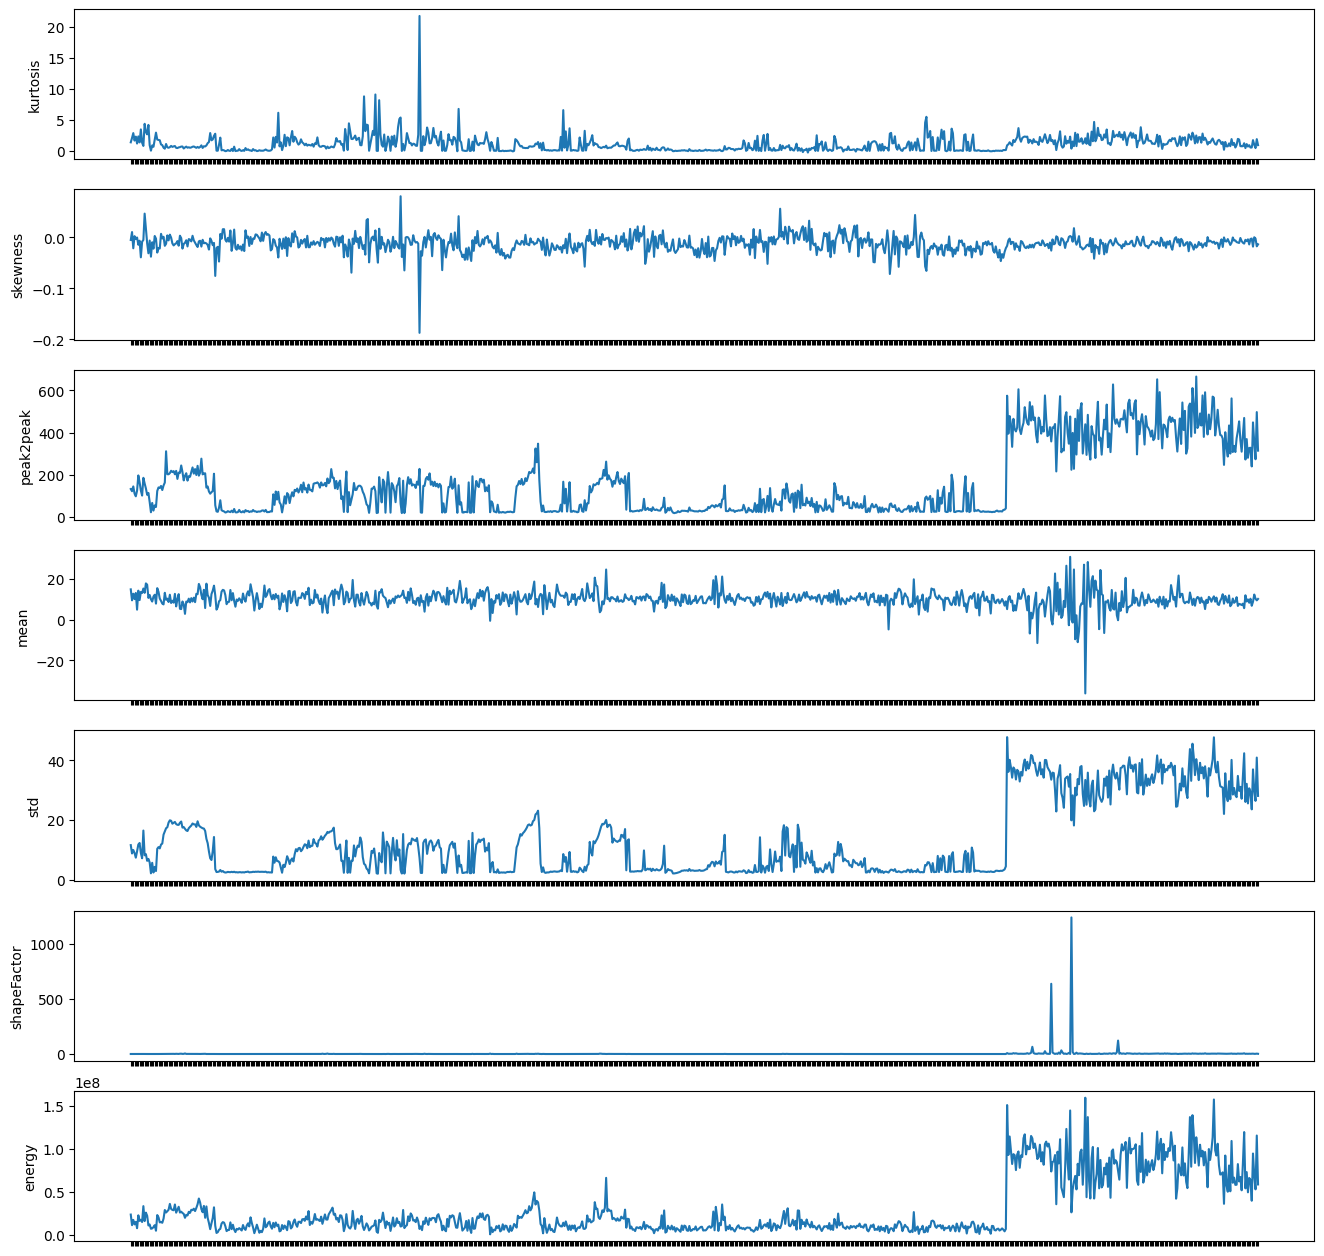

In [20]:
# run id used, cuz i fucked up run names
RUN_ID = "3fbc94286d0a4bf889137e5dc99704ca"
with mlflow.start_run(run_id=RUN_ID) as run:
    fig, ax = plt.subplots(7, figsize=(16,16))
    for i, col in enumerate(feature_dataset.columns):
        sns.lineplot(feature_dataset[col], ax=ax[i])
        ax[i].set_xticklabels("")
    plt.savefig("./artifacts/feature_dataset.png")
    mlflow.log_figure(fig, "./artifacts/feature_dataset.png")

Normilize

In [26]:
with mlflow.start_run(run_id="3fbc94286d0a4bf889137e5dc99704ca") as run:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_dataset)

    with open("./artifacts/scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    mlflow.log_artifact("./artifacts/scaler.pkl", "artifacts/utils/scaler.pkl")

Find out the number of components

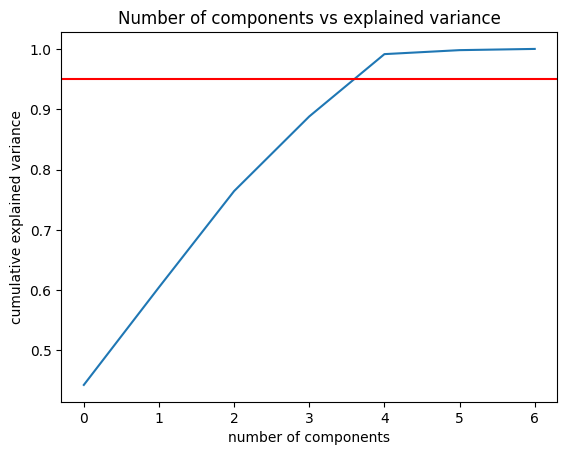

In [32]:
with mlflow.start_run(run_id="3fbc94286d0a4bf889137e5dc99704ca") as run:
    pca = PCA().fit(scaled_features)
    fig, ax = plt.subplots()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.axhline(0.95, c="red")
    ax.set_xlabel('number of components')
    ax.set_ylabel('cumulative explained variance')
    ax.set_title("Number of components vs explained variance")

    plt.savefig("./artifacts/pca_var.png")

    mlflow.log_figure(fig, "artifacts/pca_var.png")

    with open("./artifacts/pca.pkl", "wb") as f:
        pickle.dump(pca, f)
    
    mlflow.log_artifact("./artifacts/pca.pkl", "artifacts/utils/pca.pkl")


* Create new run
* Log feature dataset  
* log scaled dataset  
* log pca3 & pca4

In [43]:
runs[runs["tags.mlflow.runName"] == RUN_NAME]['run_id'][0]

'36d231c830034e888ad1e04dd67741d5'

In [39]:
# DF columns to string to log dataset
feature_dataset.columns = feature_dataset.columns.astype(str)

RUN_NAME: str = "PCA_SEACH_INDICATOR"

# GET ALL RUNS OF EXPERIMENT
# ----------
runs = mlflow.search_runs([CURRENT_EXPERIMENT.experiment_id])
# CHECK IF EXPERIMENT EXISTS
# ----------
dataset = mlflow.data.pandas_dataset.from_pandas(
    feature_dataset, 
    name="FEATURE DATASET",
    source=""
)
if runs[runs["tags.mlflow.runName"] == RUN_NAME].shape[0] == 0:
    with mlflow.start_run(run_name=RUN_NAME) as run:
        # Log dataset fields info
        mlflow.log_input(dataset, context="SEARCH HEALTH INDICATOR")
        # Log dataset csv
        mlflow.log_artifact("../data/processed/spectr/feature_dataset.csv", "artifacts/data/feature_dataset.csv")
        # Log dataset as JSON
        mlflow.log_table(feature_dataset, "artifacts/data_json/feature_dataset.json")
else:
    with mlflow.start_run(run_id=runs[runs["tags.mlflow.runName"] == RUN_NAME]['run_id'][0]):
        # LOGGING ON REPEAT OF RUN
        ...
        # # Log dataset fields info
        # mlflow.log_input(dataset, context="SEARCH HEALTH INDICATOR")
        # # Log dataset csv
        # mlflow.log_artifact("../data/processed/spectr/feature_dataset.csv", "artifacts/data/feature_dataset.csv")
        # # Log dataset as JSON
        # mlflow.log_table(feature_dataset, "artifacts/data_json/feature_dataset.json")

RUN_ID = run.info.run_id
logged_run = mlflow.get_run(run.info.run_id)

# Retrieve the Dataset object
logged_dataset = logged_run.inputs.dataset_inputs[0].dataset

# View some of the recorded Dataset information
print(f"Dataset name: {logged_dataset.name}")
print(f"Dataset digest: {logged_dataset.digest}")
print(f"Dataset profile: {logged_dataset.profile}")
print(f"Dataset schema: {logged_dataset.schema}")
    

c:\Users\egore\Desktop\predictive_RUL\.venv\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for ''. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\egore\Desktop\predictive_RUL\.venv\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


Dataset name: FEATURE DATASET
Dataset digest: 6a1946ce
Dataset profile: {"num_rows": 65535, "num_elements": 58653825}
Dataset schema: {"mlflow_colspec": [{"type": "float", "name": "2021-11-15 17:03:03", "required": true}, {"type": "float", "name": "2021-11-15 18:03:03", "required": true}, {"type": "float", "name": "2021-11-15 19:03:03", "required": true}, {"type": "float", "name": "2021-11-15 20:03:03", "required": true}, {"type": "float", "name": "2021-11-15 21:04:03", "required": true}, {"type": "float", "name": "2021-11-15 22:04:03", "required": true}, {"type": "float", "name": "2021-11-15 23:04:03", "required": true}, {"type": "float", "name": "2021-11-16 00:04:03", "required": true}, {"type": "float", "name": "2021-11-16 01:04:04", "required": true}, {"type": "float", "name": "2021-11-16 02:04:04", "required": true}, {"type": "float", "name": "2021-11-16 03:04:04", "required": true}, {"type": "float", "name": "2021-11-16 04:05:04", "required": true}, {"type": "float", "name": "202

Test 3 and 4 components (create 2 runs)

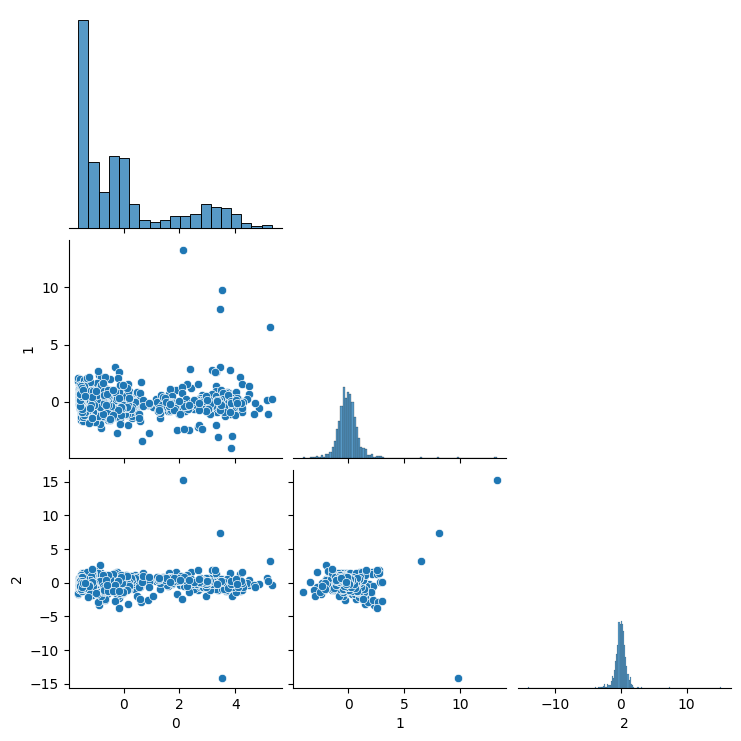

In [47]:
with mlflow.start_run(run_id="36d231c830034e888ad1e04dd67741d5") as run:
    pca = PCA(n_components=3)
    pca3 = pca.fit_transform(scaled_features)

    fig = sns.pairplot(pd.DataFrame(pca3), corner=True, kind="scatter")

    plt.savefig("./artifacts/pairplot_pca.png")

    mlflow.log_image(PIL.Image.open("./artifacts/pairplot_pca.png"), "artifacts/charts/pairplot_pca.png")

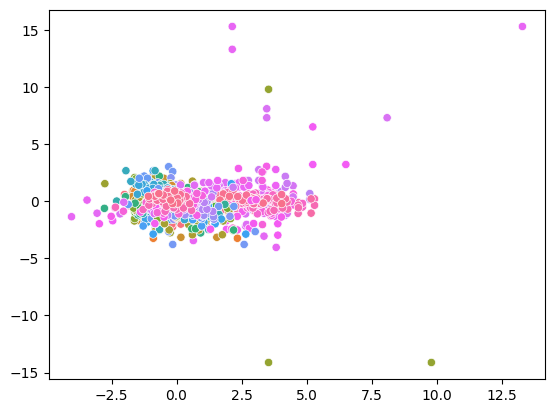

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [50]:
with mlflow.start_run(run_id="36d231c830034e888ad1e04dd67741d5") as run:
    fig, ax = plt.subplots()
    sns.scatterplot(x=pca3[:, 0], y=pca3[:, 1], hue=dates[:], legend=False, ax=ax)
    plt.savefig("./artifacts/pca1_pca2")
    mlflow.log_figure(fig, "artifacts/charts/pca1_pca2.png")
    plt.figure()
    sns.scatterplot(x=pca3[:, 0], y=pca3[:, 2], hue=dates[:], legend=False, ax=ax)
    plt.savefig("./artifacts/pca1_pca3")
    mlflow.log_figure(fig, "artifacts/charts/pca1_pca3.png")
    plt.figure()
    sns.scatterplot(x=pca3[:, 1], y=pca3[:, 2], hue=dates[:], legend=False, ax=ax)
    plt.savefig("./artifacts/pca2_pca3")
    mlflow.log_figure(fig, "artifacts/charts/pca2_pca3.png")

In [ ]:
with mlflow.start_run(run_id="36d231c830034e888ad1e04dd67741d5") as run:
    pca = PCA(n_components=4)
    pca4 = pca.fit_transform(scaled_features)
    sns.pairplot(pd.DataFrame(pca4), corner=True, kind="scatter")

    fig = sns.pairplot(pd.DataFrame(pca4), corner=True, kind="scatter")

    plt.savefig("./artifacts/pairplot_pca4.png")

    mlflow.log_image(PIL.Image.open("./artifacts/pairplot_pca4.png"), "artifacts/charts/pairplot_pca4.png")

READING REST OF THE SAMPLE DATASETS

In [60]:
df_rest = pd.read_csv(SAMPLE_REST, skiprows=16, sep=';')
df_rest.drop(columns=df_rest.columns[[0, 1]], inplace=True)

column_names = pd.to_datetime(df_rest.iloc[0, ::2].tolist(), format='%d.%m.%Y %H:%M:%S') 
df_rest = df_rest.iloc[:, 1::2]
df_rest.columns = column_names
df_rest = df_rest.sort_index(axis=1)

# Values to float
df_rest = df_rest.apply(lambda x:
              pd.to_numeric(
                  x.str.replace(',','.'),
                  errors='coerce')
              )

compress_dataset(df_rest)

C:\Users\egore\AppData\Local\Temp\ipykernel_4376\146180447.py:1: DtypeWarning: Columns (0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,198,200,202,204,206,208,210,212,214,216,218,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,320,322,324,326,328,330,332,334,336,338,340,342,344,346,348,350,352,354,356,358,360,362,364,366,368,370,372,374,376,378,380,382,384,386,388,390,392,394,396,398,400,402,404,406,408,410,412,414,416,418,420,422,424,426,428,430,432,434,436,438,440,442,444,446,448,450,452,454,456,458,460,462,464,466,468,470,472,474,476,478,480,482

Memory usage : 636.49MB

Name: 24s Type: float64
 variable min: -193.6084       max: 217.5841       
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 636.12MB
Compress Rate: [0.06%]
Name: 24s Type: float64
 variable min: -143.9975       max: 149.548        
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 635.74MB
Compress Rate: [0.12%]
Name: 24s Type: float64
 variable min: -219.3008       max: 246.9043       
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 635.37MB
Compress Rate: [0.18%]
Name: 24s Type: float64
 variable min: -185.5287       max: 218.0991       
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Memory usage : 634.99MB
Compress Rate: [0.24%]
Name: 24s Type: float64
 variable min: -287.7832       max: 292.1321       
  float16 min: -65500.0        max: 65500.0        
compress float64 --> float16
Me

In [61]:
dates_rest = df_rest.T.index
feat_dataset_rest = pd.DataFrame()
feat_dataset_rest["kurtosis"] = df_rest.apply(lambda x: stats.kurtosis(x.astype(np.float64)))
feat_dataset_rest["skewness"] = df_rest.apply(lambda x: stats.skew(x.astype(np.float64)))
feat_dataset_rest["peak2peak"] = df_rest.apply(lambda x: np.ptp(x.astype(np.float64)))
feat_dataset_rest["mean"] = df_rest.apply(lambda x: x.astype(np.float64).mean())
feat_dataset_rest["std"] = df_rest.apply(lambda x: x.astype(np.float64).std())
feat_dataset_rest["shapeFactor"] = df_rest.apply(lambda x: np.sqrt(np.mean(np.square(x.astype(np.float64)))) / np.abs(x.astype(np.float64).mean()))
feat_dataset_rest["energy"] = df_rest.apply(lambda x: np.sum(x.astype(np.float64) ** 2))
feat_dataset_rest.index = dates_rest

In [74]:
feat_dataset_rest.to_csv("../data/processed/spectr/feature_dataset_rest.csv")

In [76]:
# DF columns to string to log dataset
feat_dataset_rest.columns = feat_dataset_rest.columns.astype(str)

RUN_NAME: str = "PCA_SEACH_INDICATOR"

# GET ALL RUNS OF EXPERIMENT
# ----------
runs = mlflow.search_runs([CURRENT_EXPERIMENT.experiment_id])
# CHECK IF EXPERIMENT EXISTS
# ----------
dataset = mlflow.data.pandas_dataset.from_pandas(
    feat_dataset_rest, 
    name="FEATURE DATASET JANUARY-MARCH",
    source=""
)
if runs[runs["tags.mlflow.runName"] == RUN_NAME].shape[0] == 0:
    with mlflow.start_run(run_name=RUN_NAME) as run:
        # Log dataset fields info
        mlflow.log_input(dataset, context="SEARCH HEALTH INDICATOR")
        # Log dataset csv
        mlflow.log_artifact("../data/processed/spectr/feature_dataset.csv", "artifacts/data/feature_dataset.csv")
        # Log dataset as JSON
        mlflow.log_table(feature_dataset, "artifacts/data_json/feature_dataset.json")
else:
    with mlflow.start_run(run_id=runs[runs["tags.mlflow.runName"] == RUN_NAME]['run_id'][0]):
        # Log dataset fields info
        mlflow.log_input(dataset, context="READ 6 MONTH RANGE")
        # Log dataset csv
        mlflow.log_artifact("../data/processed/spectr/feature_dataset_rest.csv", "artifacts/data/feature_dataset_rest.csv")
        # Log dataset as JSON
        mlflow.log_table(feat_dataset_rest, "artifacts/data_json/feature_dataset_rest.json")

RUN_ID = run.info.run_id
logged_run = mlflow.get_run(run.info.run_id)

# Retrieve the Dataset object
logged_dataset = logged_run.inputs.dataset_inputs[0].dataset

# View some of the recorded Dataset information
print(f"Dataset name: {logged_dataset.name}")
print(f"Dataset digest: {logged_dataset.digest}")
print(f"Dataset profile: {logged_dataset.profile}")
print(f"Dataset schema: {logged_dataset.schema}")
    

c:\Users\egore\Desktop\predictive_RUL\.venv\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for ''. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\egore\Desktop\predictive_RUL\.venv\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2024/05/29 01:33:39 INFO mlflow.tracking.client: Appending new table to already existing artifact artifacts/data_json/feature_dataset_rest.json for run 36d231c830034e888ad1e04dd67741d5.


Dataset name: FEATURE DATASET
Dataset digest: 6a1946ce
Dataset profile: {"num_rows": 65535, "num_elements": 58653825}
Dataset schema: {"mlflow_colspec": [{"type": "float", "name": "2021-11-15 17:03:03", "required": true}, {"type": "float", "name": "2021-11-15 18:03:03", "required": true}, {"type": "float", "name": "2021-11-15 19:03:03", "required": true}, {"type": "float", "name": "2021-11-15 20:03:03", "required": true}, {"type": "float", "name": "2021-11-15 21:04:03", "required": true}, {"type": "float", "name": "2021-11-15 22:04:03", "required": true}, {"type": "float", "name": "2021-11-15 23:04:03", "required": true}, {"type": "float", "name": "2021-11-16 00:04:03", "required": true}, {"type": "float", "name": "2021-11-16 01:04:04", "required": true}, {"type": "float", "name": "2021-11-16 02:04:04", "required": true}, {"type": "float", "name": "2021-11-16 03:04:04", "required": true}, {"type": "float", "name": "2021-11-16 04:05:04", "required": true}, {"type": "float", "name": "202

In [77]:
feat_dataset_full = pd.concat([feature_dataset, feat_dataset_rest])

In [80]:
feat_dataset_full.to_csv("../data/processed/spectr/feature_dataset_full.csv")

In [81]:
# DF columns to string to log dataset
feat_dataset_full.columns = feat_dataset_full.columns.astype(str)

RUN_NAME: str = "PCA_SEACH_INDICATOR"

# GET ALL RUNS OF EXPERIMENT
# ----------
runs = mlflow.search_runs([CURRENT_EXPERIMENT.experiment_id])
# CHECK IF EXPERIMENT EXISTS
# ----------
dataset = mlflow.data.pandas_dataset.from_pandas(
    feat_dataset_full, 
    name="FEATURE DATASET JANUARY-MARCH",
    source=""
)
if runs[runs["tags.mlflow.runName"] == RUN_NAME].shape[0] == 0:
    with mlflow.start_run(run_name=RUN_NAME) as run:
        # Log dataset fields info
        mlflow.log_input(dataset, context="SEARCH HEALTH INDICATOR")
        # Log dataset csv
        mlflow.log_artifact("../data/processed/spectr/feature_dataset.csv", "artifacts/data/feature_dataset.csv")
        # Log dataset as JSON
        mlflow.log_table(feat_dataset_full, "artifacts/data_json/feature_dataset.json")
else:
    with mlflow.start_run(run_id=runs[runs["tags.mlflow.runName"] == RUN_NAME]['run_id'][0]):
        # Log dataset fields info
        mlflow.log_input(dataset, context="CONCAT 2 PART OF DATASET")
        # Log dataset csv
        mlflow.log_artifact("../data/processed/spectr/feature_dataset_full.csv", "artifacts/data/feature_dataset_full.csv")
        # Log dataset as JSON
        mlflow.log_table(feat_dataset_full, "artifacts/data_json/feature_dataset_full.json")

RUN_ID = run.info.run_id
logged_run = mlflow.get_run(run.info.run_id)

# Retrieve the Dataset object
logged_dataset = logged_run.inputs.dataset_inputs[0].dataset

# View some of the recorded Dataset information
print(f"Dataset name: {logged_dataset.name}")
print(f"Dataset digest: {logged_dataset.digest}")
print(f"Dataset profile: {logged_dataset.profile}")
print(f"Dataset schema: {logged_dataset.schema}")
    

c:\Users\egore\Desktop\predictive_RUL\.venv\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for ''. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\egore\Desktop\predictive_RUL\.venv\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


Dataset name: FEATURE DATASET
Dataset digest: 6a1946ce
Dataset profile: {"num_rows": 65535, "num_elements": 58653825}
Dataset schema: {"mlflow_colspec": [{"type": "float", "name": "2021-11-15 17:03:03", "required": true}, {"type": "float", "name": "2021-11-15 18:03:03", "required": true}, {"type": "float", "name": "2021-11-15 19:03:03", "required": true}, {"type": "float", "name": "2021-11-15 20:03:03", "required": true}, {"type": "float", "name": "2021-11-15 21:04:03", "required": true}, {"type": "float", "name": "2021-11-15 22:04:03", "required": true}, {"type": "float", "name": "2021-11-15 23:04:03", "required": true}, {"type": "float", "name": "2021-11-16 00:04:03", "required": true}, {"type": "float", "name": "2021-11-16 01:04:04", "required": true}, {"type": "float", "name": "2021-11-16 02:04:04", "required": true}, {"type": "float", "name": "2021-11-16 03:04:04", "required": true}, {"type": "float", "name": "2021-11-16 04:05:04", "required": true}, {"type": "float", "name": "202

C:\Users\egore\AppData\Local\Temp\ipykernel_4376\2383761476.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  feat_dataset_full.plot(subplots=True, ax=ax)


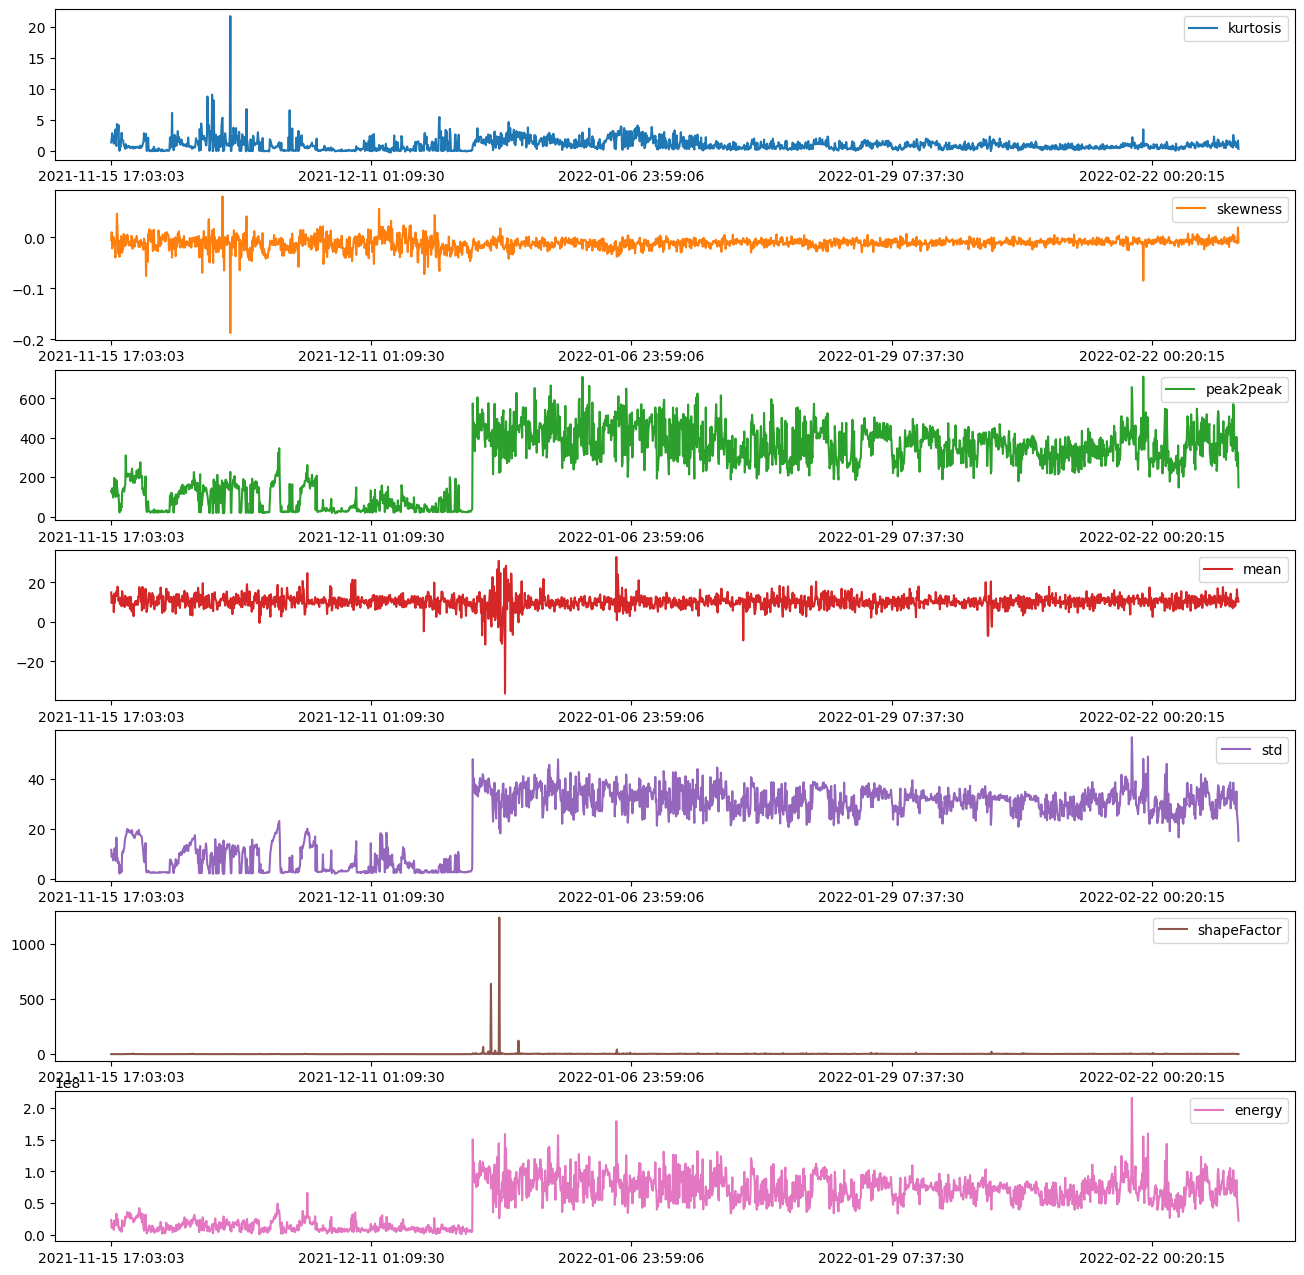

In [90]:
with mlflow.start_run(run_id="36d231c830034e888ad1e04dd67741d5") as run:
    fig, ax = plt.subplots(figsize=(16,16))
    feat_dataset_full.plot(subplots=True, ax=ax)

    mlflow.log_figure(fig, "artifacts/charts/full_signals.png")


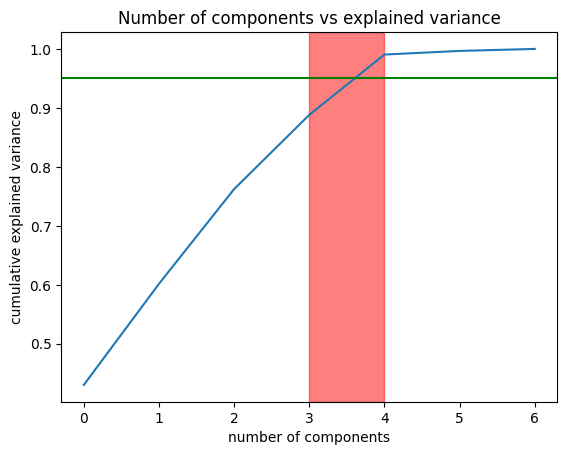

In [94]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feat_dataset_full)

pca = PCA().fit(scaled_features)
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.axhline(0.95, c="green")
ax.axvspan(3, 4, alpha=.5, color="red")
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')
ax.set_title("Number of components vs explained variance")

with mlflow.start_run(run_id="36d231c830034e888ad1e04dd67741d5") as run:
    mlflow.log_figure(fig, "artifacts/charts/components_vs_variance.png")

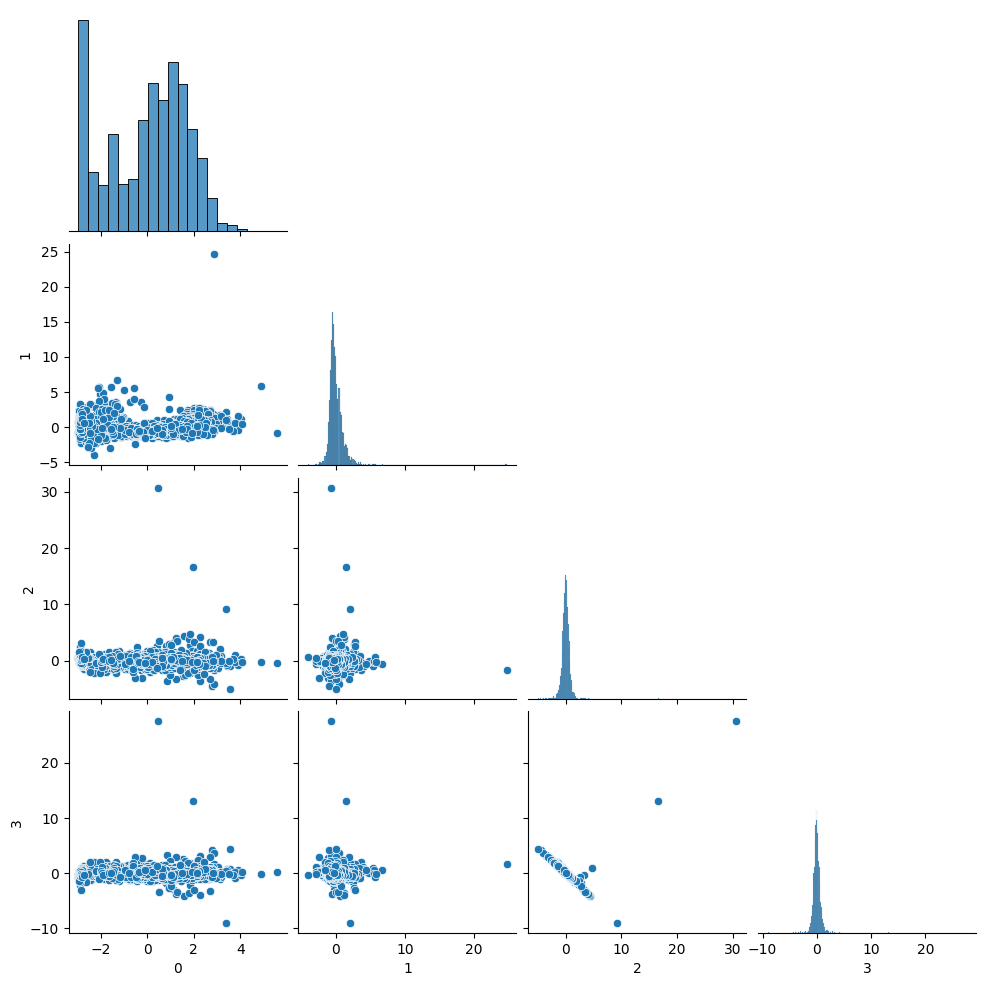

In [95]:
with mlflow.start_run(run_id="36d231c830034e888ad1e04dd67741d5") as run:
    pca = PCA(n_components=4)
    pca4 = pca.fit_transform(scaled_features)

    fig = sns.pairplot(pd.DataFrame(pca4), corner=True, kind="scatter")

    plt.savefig("./artifacts/pairplot_pca_full.png")

    mlflow.log_image(PIL.Image.open("./artifacts/pairplot_pca_full.png"), "artifacts/charts/pairplot_pca_full.png")